## Sentiment Analysis

This example uses a transformer trained to predict if the text has negative or positive sentiment. Depending on the model that is chosen, the model might or might not understand different languages. We use a dataset from https://lazyprogrammer.me to predict airline tweets to detect if they have positive or negative sentiment and display accuracy of the model.

In [1]:
# Download a sample file from the course material
! wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

--2024-03-12 14:08:03--  https://lazyprogrammer.me/course_files/AirlineTweets.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3,3M) [text/csv]
Saving to: ‘AirlineTweets.csv’

AirlineTweets.csv   100%[===================>]   3,26M  17,9MB/s    in 0,2s    

2024-03-12 14:08:04 (17,9 MB/s) - ‘AirlineTweets.csv’ saved [3421431/3421431]



In [2]:
from transformers import pipeline

import torch
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [3]:
print(f"CUDA found: {torch.cuda.is_available()}")
print(f"CUDA current device: {torch.cuda.current_device()}")

CUDA found: True
CUDA current device: 0


In [4]:
# Create a sentiment analyzer pipeline, includes tokenization and other required bits and pieces
# If available, use CUDA
if torch.cuda.is_available():
    sentiment_classifier = pipeline("sentiment-analysis", device=torch.cuda.current_device())
else:
    sentiment_classifier = pipeline("sentiment-analysis")
print(type(sentiment_classifier))

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


<class 'transformers.pipelines.text_classification.TextClassificationPipeline'>


In [5]:
# Positive example
sentiment_classifier("What a fantastic movie!")

[{'label': 'POSITIVE', 'score': 0.9998810291290283}]

In [6]:
# Negative example
sentiment_classifier("What a horrible movie!")

[{'label': 'NEGATIVE', 'score': 0.9997732043266296}]

In [7]:
# Positive example in Spanish
sentiment_classifier("La pelicula fue muy buena")

[{'label': 'NEGATIVE', 'score': 0.9425332546234131}]

In [8]:
# Negative example in Spanish
sentiment_classifier("La pelicula fue muy mala")

[{'label': 'NEGATIVE', 'score': 0.9949302077293396}]

In [9]:
# Read the airline tweets that contains customer feedback
df = pd.read_csv('AirlineTweets.csv')
print(f"COLUMN NAMES:\n{df.columns}")
print(f"HEAD:\n{df.head()}")

COLUMN NAMES:
Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')
HEAD:
             tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN      

<Axes: >

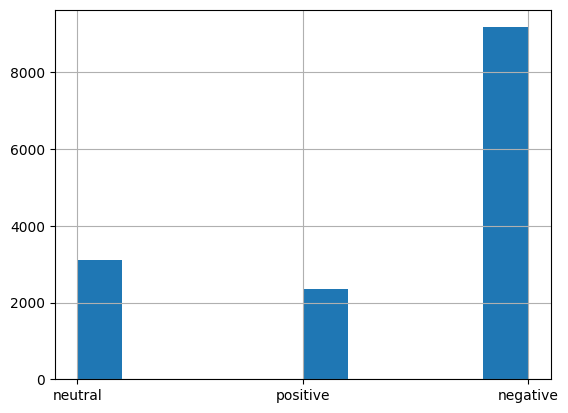

In [10]:
# Show histogram of the sentiment labels
df['airline_sentiment'].hist()

In [11]:
df_masked = df[df.airline_sentiment != "neutral"].copy()
target_map = {'positive': 1, 'negative': 0}
df_masked["target"] = df["airline_sentiment"].map(target_map)

In [12]:
print(df_masked.head())

             tweet_id airline_sentiment  airline_sentiment_confidence  \
1  570301130888122368          positive                        0.3486   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   
5  570300767074181121          negative                        1.0000   
6  570300616901320704          positive                        0.6745   

  negativereason  negativereason_confidence         airline  \
1            NaN                     0.0000  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   
5     Can't Tell                     0.6842  Virgin America   
6            NaN                     0.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
1                    NaN    jnardino                 NaN              0   
3                    NaN    jnar

In [13]:
# Extract the comments left by people to a list called 'texts' and run sentiment analysis on against it
texts = df_masked['text'].tolist()
predictions = sentiment_classifier(texts)

In [14]:
for prediction in predictions[:5]:
    print(prediction)

{'label': 'POSITIVE', 'score': 0.6070847511291504}
{'label': 'NEGATIVE', 'score': 0.9973449110984802}
{'label': 'NEGATIVE', 'score': 0.9995823502540588}
{'label': 'NEGATIVE', 'score': 0.9854250550270081}
{'label': 'POSITIVE', 'score': 0.9553212523460388}


In [15]:
# In order for us to calculate accuracy of the model the data needs to be on the same "scale".
# What the sentiment classifier gives us is the probability of the sample in question either belonging to
# the positive of the the negative class. In other words, we need a probability between [0.0...1.0].
probs = [d["score"] if d["label"].startswith("P") else 1.0 - d["score"] for d in predictions]
probs = np.array(probs)

In [16]:
# Extract prediction 1 = positive, 0 = negative from the sentiment classifier output using list comprehension
preds = [1 if p["label"].startswith("P") else 0 for p in predictions]
# Convert the list into numpy array
preds = np.array(preds)

In [17]:
# Calculate accuracy of the predictions
print(f"Accuracy: {np.mean(df_masked['target'] == preds)}")

Accuracy: 0.8898708950697514


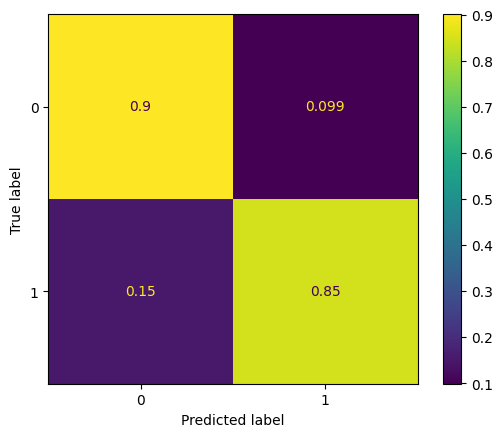

In [18]:
# Create a confusion matrix and display the results
cm = confusion_matrix(df_masked["target"], preds, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Next we calculate F1-score. The F1-score is the harmonic mean of precision and recall, where the precision is the number of true positive divided by the number of all positive results, including those not identified correctly. The limitation is that it does not take into account the true negative rate and is more focused on the positive class as we can see from the following:

In [19]:
f1_score(df_masked["target"], preds)

0.758777756690074

In [20]:
f1_score(1 - df_masked["target"], 1 - preds)

0.928647616908999

ROC AUC stands for Receiver Operating Characteristic - Area Under the Curve. ROC AUC is used when we need to evaluate the performance of a binary classification model across all possible threshold values, thus providing a measure of the model's ability to discriminate between the positive and negative classes irrespective of the classification threshold. ROC AUC gives the same score irrespective if we calculate it for the positive- or the negative class.

In [21]:
roc_auc_score(df_masked['target'], probs)

0.9485934921195112

In [22]:
roc_auc_score(1 - df_masked['target'], 1 - probs)

0.948593492119511